In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import dgl
import networkx as nx

import gsp_utils.data as data
from arch.model import RobustGNNModel1, RobustGNNModel2
from deeprobust.graph.data import Dataset, PrePtbDataset

import baselines as bs

PATH = 'results/perts_node_class/'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [2]:
# TODO: move to a common folder/file for other experiments
def get_data(dataset_class):
    dataset = getattr(dgl.data, dataset_class)(verbose=False)
    g = dataset[0]
    num_class = dataset.num_classes

    # get node feature
    feat = g.ndata['feat'].to(device)

    # get data split
    train_mask = g.ndata['train_mask'].to(device)
    val_mask = g.ndata['val_mask'].to(device)
    test_mask = g.ndata['test_mask'].to(device)

    # get labels
    label = g.ndata['label'].to(device)
    N = g.number_of_nodes()
    n_feat = feat.shape[1]

    S = g.adj().to_dense().numpy()

    return S, feat, label, n_feat, num_class, train_mask, val_mask, test_mask

In [3]:
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def test(model, g, feat, label, train_mask, val_mask, test_mask, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

    loss_train, acc_train, acc_test = [torch.zeros(n_epochs) for _ in range(3)]

    for i in range(n_epochs):
        model.train()
        y_hat = model(g, feat)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = loss_fn(y_hat[train_mask], label[train_mask])

        opt.zero_grad()
        loss.backward()
        opt.step()

        # Compute accuracy on training/validation/test
        train_acc = evaluate(g, feat, label, train_mask, model)
        val_acc = evaluate(g, feat, label, val_mask, model)
        test_acc = evaluate(g, feat, label, test_mask, model)

        loss_train[i] = loss.detach().cpu().item()
        acc_train[i] = train_acc
        acc_test[i] = test_acc

        if (i == 0 or (i+1) % eval_freq == 0) and verbose:
            print(f"Epoch {i+1}/{n_epochs} - Loss Train: {loss_train[i]} - Acc Train: {acc_train[i]} - Acc Val: {val_acc} - Acc Test: {acc_test[i]}", flush=True)

    return loss_train, acc_train, acc_test

## Cora dataset

In [4]:
S, feat, label, in_dim, out_dim, train_mask, val_mask, test_mask = get_data("CoraGraphDataset")
S = torch.Tensor(S).to(device)

# Data description
N = S.shape[0]
norm_S = torch.linalg.norm(S, 'fro')
print(f'Number of nodes: {S.shape[0]}')
print(f'Number of features: {in_dim}')
print(f'Shape of signals: {feat.shape}')
print(f'Number of classes: {out_dim}')
print(f'Norm of A: {norm_S}')
print(f'Max value of A: {torch.max(S)}')
print(f'Proportion of validation data: {torch.sum(val_mask == True).item()/N:.2f}')
print(f'Proportion of test data: {torch.sum(test_mask == True).item()/N:.2f}')

# print(label[:10])

# print(np.linalg.norm(S,'fro'))
# print(np.max(S))

# plt.figure()
# plt.imshow(S)
# plt.colorbar()
# plt.title('Cora Adjacency')



Number of nodes: 2708
Number of features: 1433
Shape of signals: torch.Size([2708, 1433])
Number of classes: 7
Norm of A: 102.74239349365234
Max value of A: 1.0
Proportion of validation data: 0.18
Proportion of test data: 0.37


In [5]:
## params - Model 1
lr = 5e-3 #5e-3
wd = 5e-4  # 1e-3 # 5e-4
eval_freq = 5  # 20
lr_S = 5e-3 #1e-3

n_iters =  4
n_iters_S = 15  #50 
n_iters_H = 25 #50
hid_dim = 16 
n_layers = 2

model_params = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'K': 2,
    'nonlin': nn.ReLU, 
    'last_nonlin': None,
    'bias': False,
}

# Bank of filters
model_params_bank = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'K': 2,
    'nonlin': nn.Identity, 
    'last_nonlin': None,
    'bias': False,
}


## Experiments
EXPS = [
    # Robust models
    {
        "layer": "RobustGNN1",  "m_params": model_params, "legend": "RobustGCN-H", "fmt": "bo-"
    },
    {
        "layer": "RobustGNN1", "m_params": model_params_bank, "legend": "Filter Bank", "fmt": "yx-"
    },

    # Baselines
    {
        "layer": "GCN", "act": nn.ReLU(), "last_act": None, "bias": False, 
        "legend": "GCN", "fmt": "gp--",
    },
    {
        "layer": "GAT",  "act": nn.ReLU(), "last_act": None, "legend": "GAT", "fmt": "rs--"
    },
    {
        "layer": "GNN-H", "act": nn.ReLU(), "last_act": None, "m_params": model_params,
        "legend": "GCN-H", "fmt": "co--"
    },
    # {
    #     "layer": "RobustGNN2", "act": nn.ReLU(), "last_act": None, "legend": "RobustGNN2",
    # },
]



lambd = 1  # 1
beta = .01 #.01  #.1 #0.01
gamma = 0  #1


## params - for baselines
# n_epochs = n_iters_H
n_epochs = n_iters*n_iters_H
hid_dim_gcn = 16
hid_dim_gat = 8
num_heads = 8
gat_params = {
    'feat_drop': 0.6,
    'attn_drop': 0.6
}

In [7]:
perts = [0, .1, .2, .3, .4, .5]
n_graphs = 30  # 50

accs_test = np.zeros((n_graphs, len(EXPS), len(perts)))
for i, p in enumerate(perts):
    for n in range(n_graphs):
        Sn_np = data.pert_S(S.cpu().numpy(), eps=p)
        g = dgl.from_networkx(nx.from_numpy_array(Sn_np)).add_self_loop().to(device)
        Sn = torch.Tensor(Sn_np).to(device)
        err_S_Sn = torch.linalg.norm(Sn - S, 'fro')/norm_S
        print(f"Pert {p} Graph {n+1} err(S-Sn): {err_S_Sn:.3f}")

        for j, exp in enumerate(EXPS):
            print(f"- Exp {exp['legend']}:", end="")

            if exp['layer'] == "GCN":
                model = bs.GCN(in_dim, hid_dim_gcn, out_dim, act=exp['act'], last_act=exp['last_act'],
                            bias=exp['bias']).to(device)
            elif exp['layer'] == "GAT":
                model = bs.GAT(in_dim, hid_dim_gat, out_dim, num_heads, gat_params, act=exp['act'],
                            last_act=exp['last_act']).to(device)
                
            elif exp['layer'] == "GNN-H":
            # non-robust GCNN using a generic H for the conv
                model = RobustGNNModel1(Sn, n_epochs, lr, wd, lr_S, eval_freq, exp['m_params'],
                                        n_iters, n_iters_S, problem_type="clas")
                model.model = model.model.to(device)
            elif exp['layer'] == "RobustGNN1":
                S_init = torch.zeros(Sn_np.shape, device=device)
                # S_init = Sn
                model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, exp['m_params'],
                                        n_iters, n_iters_S, problem_type="clas", reduct='mean')
            elif exp['layer'] == "RobustGNN2":
                model = RobustGNNModel2(Sn, n_iters_H, lr, wd, lr_S, eval_freq, model_params_m2, n_iters, n_iters_S, problem_type="clas")
            else:
                raise Exception('Unknown layer type')

            if exp['layer'] in ["GCN", "GAT"]:
                # model training
                loss_train, acc_train, acc_test = test(model, g, feat, label, train_mask, val_mask, test_mask, False)
                err_S_est = err_S_Sn
            elif exp['layer'] == "GNN-H":
                _, _, acc_test, _ = model.stepH(feat, label, train_mask, val_mask, test_mask)
                err_S_est = err_S_Sn
            else:
                model.model = model.model.to(device)
                results_m1, S_dict_m1 = \
                    model.test_model(Sn, feat, label, gamma, lambd, beta, train_idx=train_mask, val_idx=val_mask,
                                    test_idx=test_mask, S_true=S, verbose=False, debug_S=False, debug_H=False)
                
                err_S_est = S_dict_m1['errs_S'][-1,-1]
                acc_test = results_m1['accs_test'][-1]

            accs_test[n, j, i] = acc_test[-1]

            print(f"DONE - Accuracy Test: {accs_test[n, j, i]:.4f} - Err S_est: {err_S_est:.4f}")
            #print(f"DONE - Accuracy Test: {np.mean(accs_test, 0)[j,i]:.4f}")

Pert 0 Graph 1 err(S-Sn): 0.000
- Exp RobustGCN-H:DONE - Accuracy Test: 0.7460 - Err S_est: 0.7995
- Exp Filter Bank:DONE - Accuracy Test: 0.7370 - Err S_est: 0.7995
- Exp GCN:DONE - Accuracy Test: 0.7340 - Err S_est: 0.0000
- Exp GAT:DONE - Accuracy Test: 0.7880 - Err S_est: 0.0000
- Exp GCN-H:DONE - Accuracy Test: 0.7850 - Err S_est: 0.0000
Pert 0 Graph 2 err(S-Sn): 0.000
- Exp RobustGCN-H:DONE - Accuracy Test: 0.7080 - Err S_est: 0.7995
- Exp Filter Bank:DONE - Accuracy Test: 0.7350 - Err S_est: 0.7995
- Exp GCN:DONE - Accuracy Test: 0.7750 - Err S_est: 0.0000
- Exp GAT:DONE - Accuracy Test: 0.8070 - Err S_est: 0.0000
- Exp GCN-H:DONE - Accuracy Test: 0.7720 - Err S_est: 0.0000
Pert 0 Graph 3 err(S-Sn): 0.000
- Exp RobustGCN-H:DONE - Accuracy Test: 0.7200 - Err S_est: 0.7995
- Exp Filter Bank:DONE - Accuracy Test: 0.7350 - Err S_est: 0.7995
- Exp GCN:DONE - Accuracy Test: 0.7390 - Err S_est: 0.0000
- Exp GAT:DONE - Accuracy Test: 0.7940 - Err S_est: 0.0000
- Exp GCN-H:DONE - Accurac

KeyboardInterrupt: 

Text(0, 0.5, 'Mean accuracy')

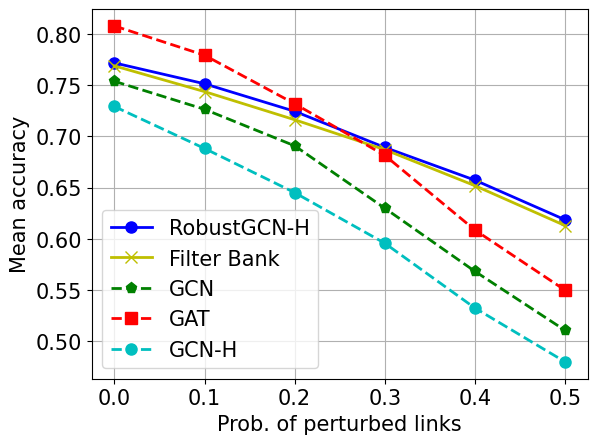

In [25]:
mean_err = np.mean(accs_test,0)

plt.figure()
for i, exp in enumerate(EXPS):
    plt.plot(perts, mean_err[i,:], exp['fmt'], label=exp['legend'], linewidth=2, markersize=8)
plt.legend()
plt.grid()
plt.xlabel('Prob. of perturbed links')
plt.ylabel('Mean accuracy')

# plt.savefig(PATH + 'error_cora_with_bankfilters.png')
# plt.savefig(PATH + 'error_cora_with_bankfilters_v3.eps')

In [22]:
# # Save data
# save_data = {'perts': perts, 'accs_test': accs_test, 'EXPS': EXPS}
# np.save(PATH + 'error_cora', save_data)

In [10]:
# ## LOAD
# file = PATH + 'error_cora.npy'
# loaded_data = np.load(file, allow_pickle=True).item()
# perts = loaded_data['perts']
# EXPS = loaded_data['EXPS']
# accs_test = loaded_data['accs_test']


## Citeseer dataset

In [11]:
S, feat, label, in_dim, out_dim, train_mask, val_mask, test_mask = get_data("CiteseerGraphDataset")
S = torch.Tensor(S).to(device)

# Data description
norm_S = torch.linalg.norm(S, 'fro')
print(f'Number of nodes: {S.shape[0]}')
print(f'Number of features: {in_dim}')
print(f'Number of signals: {feat.shape}')
print(f'Number of classes: {out_dim}')
print(f'Norm of A: {norm_S}')
print(f'Max value of A: {torch.max(S)}')
print(f'Proportion of validation data: {torch.sum(val_mask == True).item()/N:.2f}')
print(f'Proportion of test data: {torch.sum(test_mask == True).item()/N:.2f}')


Number of nodes: 3327
Number of features: 3703
Number of signals: torch.Size([3327, 3703])
Number of classes: 6
Norm of A: 96.0624771118164
Max value of A: 1.0
Proportion of validation data: 0.18
Proportion of test data: 0.37


In [12]:
## params - Model 1
n_epochs = 50
lr = 5e-3
wd = 5e-4
eval_freq = 1  # 20
lr_S = 5e-3

n_iters = 5 #20
n_iters_H = 25 #50
n_iters_S = 15
hid_dim = 16
n_layers = 2



model_params = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'K': 2,
    'nonlin': nn.ReLU, 
    'last_nonlin': None,
    'bias': False,
}

lambd = 1  # 1
beta = .01 #.01  #.1 #0.01
gamma = 0  #1

## params - for baselines
n_epochs = n_iters*n_iters_H
hid_dim_gcn = 16
hid_dim_gat = 8
num_heads = 8
gat_params = {
    'feat_drop': 0.6,
    'attn_drop': 0.6
}

In [13]:
perts = [0, .1, .2, .3, .4, .5]
n_graphs = 30

accs_test2 = np.zeros((n_graphs, len(EXPS), len(perts)))


for i, p in enumerate(perts):
    for n in range(n_graphs):
        Sn_np = data.pert_S(S.cpu().numpy(), eps=p)
        g = dgl.from_networkx(nx.from_numpy_array(Sn_np)).add_self_loop().to(device)
        Sn = torch.Tensor(Sn_np).to(device)
        err_S_Sn = torch.linalg.norm(Sn - S, 'fro')/norm_S
        print(f"Pert {p} Graph {n+1} err(S-Sn): {err_S_Sn:.3f}")

        for j, exp in enumerate(EXPS):
            print(f"- Exp {exp['legend']}: ", end="")

            if exp['layer'] == "GCN":
                model = bs.GCN(in_dim, hid_dim_gcn, out_dim, act=exp['act'], last_act=exp['last_act'],
                            bias=exp['bias']).to(device)
            elif exp['layer'] == "GAT":
                model = bs.GAT(in_dim, hid_dim_gat, out_dim, num_heads, gat_params, act=exp['act'],
                            last_act=exp['last_act']).to(device)
                
            elif exp['layer'] == "GNN-H":
            # non-robust GCNN using a generic H for the conv
                model = RobustGNNModel1(Sn, n_epochs, lr, wd, lr_S, eval_freq, model_params,
                                        n_iters, n_iters_S, problem_type="clas")
                model.model = model.model.to(device)
            elif exp['layer'] == "RobustGNN1":
                S_init = torch.zeros(Sn_np.shape, device=device)
                model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params,
                                        n_iters, n_iters_S, problem_type="clas")
            elif exp['layer'] == "RobustGNN2":
                model = RobustGNNModel2(Sn, n_iters_H, lr, wd, lr_S, eval_freq, model_params_m2, n_iters, n_iters_S, problem_type="clas")
            else:
                raise Exception('Unknown layer type')

            if exp['layer'] in ["GCN", "GAT"]:
                # model training
                loss_train, acc_train, acc_test = test(model, g, feat, label, train_mask, val_mask, test_mask, False)
            elif exp['layer'] == "GNN-H":
                _, _, acc_test, _ = model.stepH(feat, label, train_mask, val_mask, test_mask)
            else:
                model.model = model.model.to(device)
                accs_train_m1, accs_test_rgnn, S_id_m1, errs_S_m1, change_S_m1 = \
                    model.test_model(Sn, feat, label, gamma, lambd, beta, train_idx=train_mask, val_idx=val_mask,
                                    test_idx=test_mask, S_true=S, verbose=False, debug_S=False)
                acc_test = accs_test_rgnn[-1]

            accs_test2[n, j, i] = acc_test[-1]

            print(f"DONE - Accuracy Test: {accs_test2[n, j, i]:.4f}")
            #print(f"DONE - Accuracy Test: {np.mean(accs_test, 0)[j,i]:.4f}")

Pert 0 Graph 1 err(S-Sn): 0.000
- Exp RobustGCN-H: DONE - Accuracy Test: 0.6750
- Exp Filter Bank: DONE - Accuracy Test: 0.6710
- Exp GCN: DONE - Accuracy Test: 0.6650
- Exp GAT: DONE - Accuracy Test: 0.6740
- Exp GCN-H: DONE - Accuracy Test: 0.6380
Pert 0 Graph 2 err(S-Sn): 0.000
- Exp RobustGCN-H: DONE - Accuracy Test: 0.6740
- Exp Filter Bank: DONE - Accuracy Test: 0.6630
- Exp GCN: DONE - Accuracy Test: 0.6780
- Exp GAT: DONE - Accuracy Test: 0.6930
- Exp GCN-H: DONE - Accuracy Test: 0.6430
Pert 0 Graph 3 err(S-Sn): 0.000
- Exp RobustGCN-H: DONE - Accuracy Test: 0.6650
- Exp Filter Bank: DONE - Accuracy Test: 0.6700
- Exp GCN: DONE - Accuracy Test: 0.6410
- Exp GAT: DONE - Accuracy Test: 0.6950
- Exp GCN-H: DONE - Accuracy Test: 0.6710
Pert 0 Graph 4 err(S-Sn): 0.000
- Exp RobustGCN-H: DONE - Accuracy Test: 0.6380
- Exp Filter Bank: DONE - Accuracy Test: 0.6770
- Exp GCN: DONE - Accuracy Test: 0.6560
- Exp GAT: DONE - Accuracy Test: 0.7010
- Exp GCN-H: DONE - Accuracy Test: 0.6400


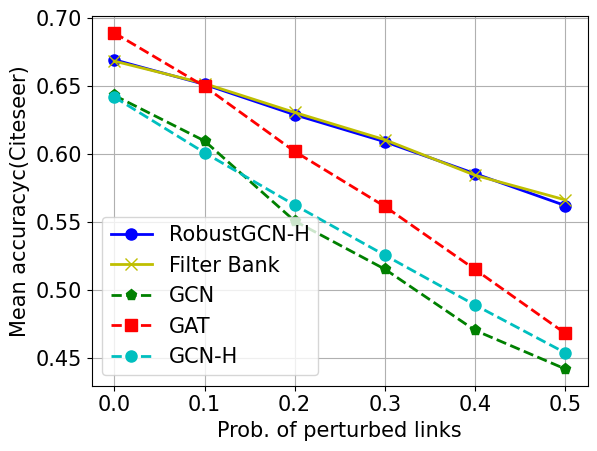

In [20]:
mean_err = np.mean(accs_test2,0)

plt.figure()
for i, exp in enumerate(EXPS):
    plt.plot(perts, mean_err[i,:], exp['fmt'], label=exp['legend'], linewidth=2, markersize=8)
plt.legend()
plt.grid()
plt.xlabel('Prob. of perturbed links')
plt.ylabel('Mean accuracyc(Citeseer)')

# plt.savefig(PATH + 'error_citeseer_with_bankfilters.png')
# plt.savefig(PATH + 'error_citeseer_with_bankfilters_v3.eps')

Text(0, 0.5, 'Mean accuracyc(Citeseer)')

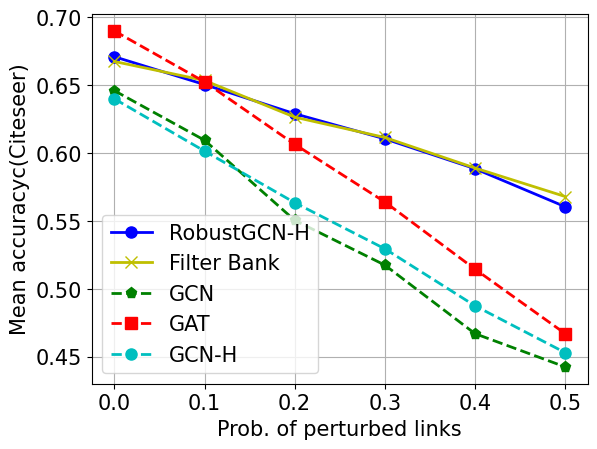

In [21]:
mean_err = np.median(accs_test2,0)

plt.figure()
for i, exp in enumerate(EXPS):
    plt.plot(perts, mean_err[i,:], exp['fmt'], label=exp['legend'], linewidth=2, markersize=8)
plt.legend()
plt.grid()
plt.xlabel('Prob. of perturbed links')
plt.ylabel('Mean accuracyc(Citeseer)')

# plt.savefig(PATH + 'error_citeseer_with_bankfilters.png')
# plt.savefig(PATH + 'error_citeseer_with_bankfilters_v3.eps')

In [19]:
# # # Save data
# save_data = {'perts': perts, 'accs_test2': accs_test2, 'EXPS': EXPS}
# np.save(PATH + 'error_citeseer', save_data)

In [17]:
# ## LOAD
# file = 'results/error_citeseer_v2.npy'
# loaded_data = np.load(file, allow_pickle=True).item()
# perts = loaded_data['perts']
# EXPS = loaded_data['EXPS']
# accs_test2 = loaded_data['accs_test2']